# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.models as models 

import json

from PIL import Image

from collections import OrderedDict

import time
from time import time, sleep

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# DONE: Define your transforms for the training, validation, and testing sets
data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                                transforms.Resize(224),
                                                transforms.RandomCrop(224),
                                                transforms.RandomHorizontalFlip(), 
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                                     [0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(224),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])]),
                   'validation': transforms.Compose([transforms.Resize(224),
                                                     transforms.CenterCrop(224),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                                          [0.229, 0.224, 0.225])])}

# DONE: Load the datasets with ImageFolder
image_datasets = {'train': datasets.ImageFolder(train_dir, transform = data_transforms['train']),
                  'test': datasets.ImageFolder(test_dir, transform = data_transforms['test']),
                  'validation': datasets.ImageFolder(valid_dir, transform = data_transforms['validation'])}

# DONE: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 64, shuffle = True),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size = 64),
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size = 64)}


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# DONE: Build and train your network

## LOADING A PRE-TRAINED NETWORK: vgg11

# Importing a pretrained network
our_model = models.vgg11(pretrained = True)

# Turning off gradients of features
for param in our_model.parameters():
    param.requires_grad = False

# Sizes of inputs layer, hidden layers, output layer, dropout value and learning rate value
input_size = our_model.classifier[0].in_features
hidden_layers = [4000, 1000]
output_size = 102
drop_out = 0.4
learning_rate = 0.001

# As we only have 102 categories of flowers, we want to change the classifier's output of vgg into 102 outputs
# We put intermediate hidden layer of 4000 and 1000 units
ordered_dict = OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_layers[0])),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(drop_out)),
                          ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(drop_out)),
                          ('fc3', nn.Linear(hidden_layers[1], output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ])

classifier = nn.Sequential(ordered_dict)

In [6]:
our_model.classifier = classifier
our_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device is: ', device)

device is:  cuda


In [8]:
# Function that tests overfitting of the training model below
def validation(model, test_loader, criterion):
       
    model.to('cuda')
    model.eval()
    
    test_loss = 0
    accuracy = 0
        
    # Looping through the validation datas in order to get the loss values
    for images, labels in test_loader:
        
        # Calling GPU
        images, labels = images.to('cuda'), labels.to('cuda')
        
        # Forward pass with new inputs never seen by the network
        output = model.forward(images)
        
        # TEST LOSS
        # Computation of the loss values
        test_loss += criterion(output, labels).item()
        
        # ACCURACY 
        # The output of the network is a log softmax so we need to 'undo' the log part
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy

In [9]:
# Choosing the classifier and the optimizer as NLLLoss and Adam respectively
# We only train the classifier parameters, the features parameters are frozen
criterion = nn.NLLLoss()
optimizer = optim.Adam(our_model.classifier.parameters(), lr = learning_rate)

# Choosing arbitrary numbers of epochs and number of print_every
epochs = 2
print_every = 5

In [10]:
## TRAINING THE NETWORK

print('*** STARTING TRAINING ***')

# Training function implementation
start_time = time()
steps = 0
    
# Using GPU to do calculations for nn
our_model.to(device)
    
# Activation of training mode of the network
our_model.train()
    
for e in range(epochs):
    running_loss = 0
        
    # Looping throught the train laoders
    for inputs, labels in dataloaders['train']:
        steps += 1
        
        # Settings to GPU for calculations
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
            
        ## FORWARD & BACKPROPAGATION
           
        optimizer.zero_grad()
        
        output = our_model.forward(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
            
        # When it is time to print
        if steps % print_every == 0:
                
            # We make sure that the network is in eval mode for Inference by turning off autograd
            our_model.eval()
            
            with torch.no_grad():
                test_loss, accuracy = validation(our_model, dataloaders['validation'], criterion)
                
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Training Loss: {:.4f}".format(running_loss/print_every),
                  "Valid Loss: {:.4f}".format(test_loss/len(dataloaders['validation'])),
                  "Valid Accuracy: {:.4f}".format(accuracy/len(dataloaders['validation'])))
                
            running_loss = 0
                
            # We make sure that the network is in train mode again, by turning on autograd
            our_model.train()           

print('*** Network is Trained ***') 
print('\nFinal Training Loss: {:.4f} Final Valid Loss: {:.4f} Final Valid Accuracy: {:.4}'.format(running_loss/print_every, test_loss/len(dataloaders['validation']), accuracy/len(dataloaders['validation'])))            
           
# Time it took to train the model created            
tot_time_batch = time() - start_time
hours = int(tot_time_batch/3600)
minutes = int((tot_time_batch%3600)/60)
seconds = int((tot_time_batch%360)%60)
print("\n** Time per batch: {} seconds".format(tot_time_batch/epochs))
print("\n** Total Elapsed Runtime: {}:{}:{}".format(hours,minutes,seconds))

*** STARTING TRAINING ***
Epoch: 1/2...  Training Loss: 1.0459 Valid Loss: 4.6818 Valid Accuracy: 0.0797
Epoch: 1/2...  Training Loss: 0.9022 Valid Loss: 4.2313 Valid Accuracy: 0.1215
Epoch: 1/2...  Training Loss: 0.8645 Valid Loss: 3.8272 Valid Accuracy: 0.2381
Epoch: 1/2...  Training Loss: 0.7494 Valid Loss: 3.4700 Valid Accuracy: 0.2634
Epoch: 1/2...  Training Loss: 0.6238 Valid Loss: 3.0785 Valid Accuracy: 0.3451
Epoch: 1/2...  Training Loss: 0.6716 Valid Loss: 2.6874 Valid Accuracy: 0.4075
Epoch: 1/2...  Training Loss: 0.5220 Valid Loss: 2.4514 Valid Accuracy: 0.4532
Epoch: 1/2...  Training Loss: 0.4727 Valid Loss: 2.0668 Valid Accuracy: 0.5003
Epoch: 1/2...  Training Loss: 0.4719 Valid Loss: 1.8033 Valid Accuracy: 0.5584
Epoch: 1/2...  Training Loss: 0.4149 Valid Loss: 1.6103 Valid Accuracy: 0.6116
Epoch: 1/2...  Training Loss: 0.4180 Valid Loss: 1.4935 Valid Accuracy: 0.6379
Epoch: 1/2...  Training Loss: 0.3230 Valid Loss: 1.3380 Valid Accuracy: 0.6379
Epoch: 1/2...  Training Lo

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [11]:
# DONE: Do validation on the test set
testing_valid = validation(our_model, dataloaders['test'], criterion)
print('Validation loss: {:.4f}'.format(testing_valid[0]/len(dataloaders['test'])))
print('Validation accuracy: {:.4f}'.format(testing_valid[1].numpy()/len(dataloaders['test'])))

Validation loss: 0.6411
Validation accuracy: 0.8115


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# Parameters needed to be save if ever needed when loading the model
our_model.arch_name = 'vgg11'
our_model.class_to_idx = image_datasets['train'].class_to_idx
our_model.input_size = input_size
our_model.batch_size = dataloaders['train'].batch_size
our_model.learning_rate = learning_rate
our_model.optimizer_state_dict = optimizer.state_dict

In [13]:
# DONE: Save the checkpoint 
def save_checkpoint(name_checkpoint, model):
    checkpoint = {'state_dict': model.state_dict(),
                  'classifier': model.classifier,
                  'mapping_train': model.class_to_idx,
                  'input_size': model.input_size,
                  'batch_size': model.batch_size,
                  'learning_rate': model.learning_rate,
                  'arch_name': model.arch_name,
                  'optimizer_state_dict': model.optimizer_state_dict}
    torch.save(checkpoint, name_checkpoint)

In [14]:
save_checkpoint('checkpoint_part1.pth', our_model)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# DONE: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint_vgg11(filepath):
    
    checkpoint = torch.load(filepath)
    
    new_model = models.vgg11(pretrained = True)
    
    # Loading old parameters from the saved model into the new model
    new_model.classifier = checkpoint['classifier']
    new_model.class_to_idx = checkpoint['mapping_train']
    new_model.input_size = checkpoint['input_size']
    new_model.batch_size = checkpoint['batch_size']
    new_model.learning_rate = checkpoint['learning_rate']
    new_model.optimizer_state_dict = checkpoint['optimizer_state_dict']
    new_model.arch_name = checkpoint['arch_name']
    new_model.load_state_dict(checkpoint['state_dict'])
        
    return(new_model)

In [16]:
our_model = load_checkpoint_vgg11('checkpoint_part1.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
# DONE: Process a PIL image for use in a PyTorch model
def process_image(image_pil):
    # Scales, crops, and normalizes a PIL image for a PyTorch model,
    # returns an Numpy array
    
    # Returns an Image object
    image_pil = Image.open(image_pil)
    
    size_ratio = float(image_pil.size[0])/float(image_pil.size[1])
        
    # Resizing the image while keeping the ratio aspect
    # size_ratio < 1: horizontal picture
    if size_ratio < 1:
        resized_image = image_pil.resize((256,int(256/size_ratio)))
        
    # size_ratio >1: vertical picture
    elif size_ratio > 1:
        resized_image = image_pil.resize((int(256*size_ratio), 256))
        
    # size_ratio == 1: square picture
    elif size_ratio == 1:
        resized_image = image_pil.resize((256,256))
    
    # The tuple below (a,b,c,d) means a, b, c and d are for the 
    # left, top, right and lower side of rectangle respectively
    image_pil = image_pil.crop((16,16,256, 256))
    
    # Converts the color channels into 0-1 instead of 0-255
    np_image = np.array(image_pil)/255
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # We want to substract the mean from each color channel and divide by the standard deviation
    norm_image_pil = (np_image - mean)/std
    
    # Changing the dimension of color channel to be 1st and the other unchanged
    final_image_pil = norm_image_pil.transpose((2,0,1))
    
    return(final_image_pil)

In [18]:
process_image('flowers/test/100/image_07897.jpg')

array([[[-0.09718298, -0.11430773, -0.14855724, ...,  0.05693981,
          0.0226903 ,  0.03981505],
        [-0.09718298, -0.11430773, -0.14855724, ...,  0.03981505,
          0.00556554,  0.00556554],
        [-0.09718298, -0.11430773, -0.13143249, ...,  0.07406456,
          0.03981505,  0.0226903 ],
        ..., 
        [ 0.05693981,  0.05693981,  0.05693981, ..., -0.21705625,
         -0.57667609,  1.03305077],
        [ 0.05693981,  0.03981505,  0.03981505, ...,  1.25567257,
         -0.50817707,  0.19393784],
        [ 0.03981505,  0.03981505,  0.0226903 , ...,  1.5810429 ,
          1.39267061,  0.4679339 ]],

       [[ 0.62535014,  0.60784314,  0.57282913, ...,  0.62535014,
          0.62535014,  0.64285714],
        [ 0.62535014,  0.60784314,  0.57282913, ...,  0.59033613,
          0.60784314,  0.60784314],
        [ 0.62535014,  0.60784314,  0.59033613, ...,  0.62535014,
          0.64285714,  0.62535014],
        ..., 
        [ 0.73039216,  0.73039216,  0.73039216, ...,

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [19]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

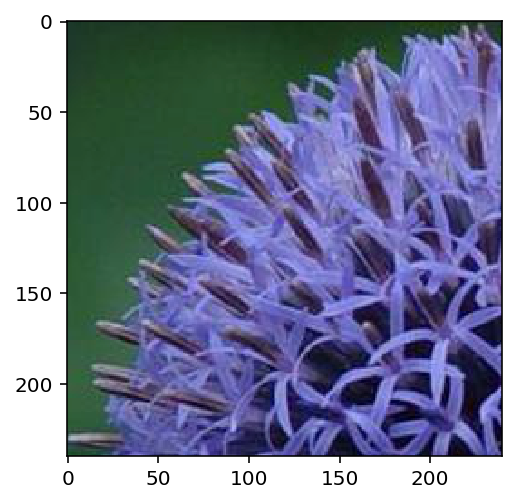

In [20]:
imshow(process_image('flowers/test/10/image_07090.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [21]:
# DONE: Implement the code to predict the class from an image file
def predict(image_path, model, topk=5):
    #Predict the class (or classes) of an image using a trained deep learning model.

    model.to('cuda')
    
    model = model.double()
    model.eval()
    
    # Preparaing the image for processing
    ndarray_processed_image = process_image(image_path)
    torch_image = torch.from_numpy(ndarray_processed_image)
    torch_image = torch_image.unsqueeze_(0)
    
    torch_image = torch_image.to('cuda')
    
    with torch.no_grad():
        output = model.forward(torch_image)
    
    ps = torch.exp(output)
    
    probs_outputs, classes_outputs = ps.topk(5, largest = True)
    probs_outputs, classes_outputs = probs_outputs.cpu().numpy(), classes_outputs.cpu().numpy()
    
    # The values returned by the topk function along with the probabilities 
    # are the values of this dictionary. You need to find the corresponding keys,
    # which are the actual class idx
    
    return(probs_outputs[0], classes_outputs[0])

In [22]:
probs, classes = predict('flowers/test/10/image_07090.jpg', our_model)
print('probabilities: ', probs)
print('classes: ', classes)

probabilities:  [ 0.36649443  0.25844688  0.09076976  0.07957114  0.03950981]
classes:  [48 94 27 29 19]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

Flower Names  Probabilities
common dandelion       0.366494
        bee balm       0.258447
       carnation       0.090770
love in the mist       0.079571
      red ginger       0.039510


Text(0.5,1,'Common Dandelion')

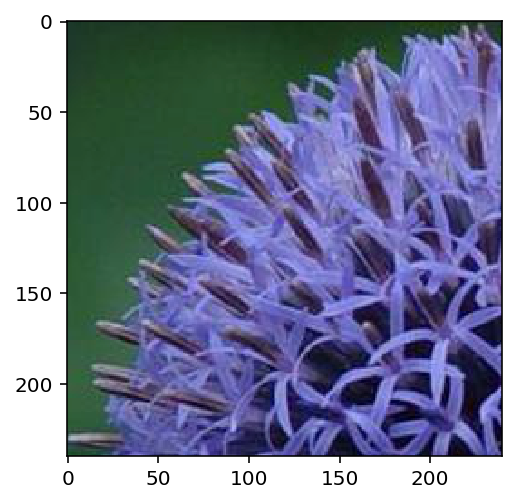

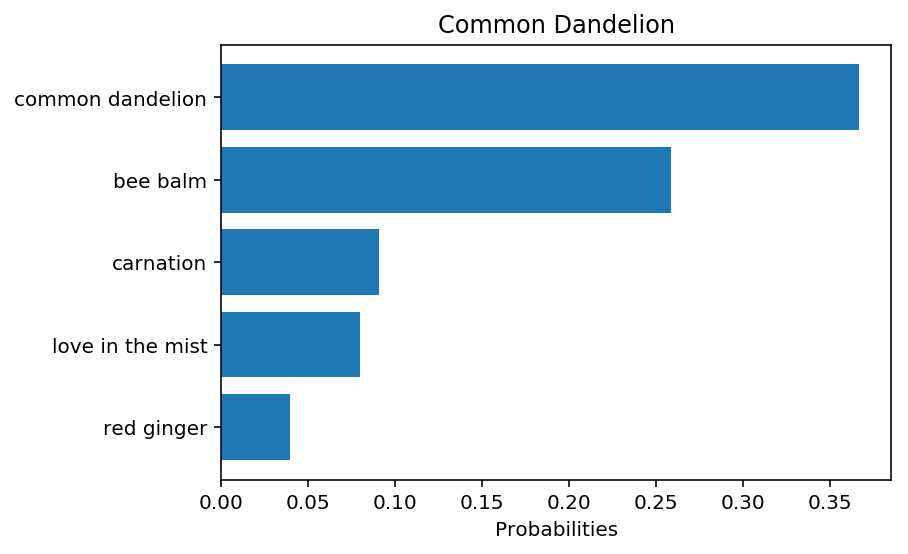

In [23]:
# Done: Display an image along with the top 5 classes
imshow(process_image('flowers/test/10/image_07090.jpg'))
probs_san_check, classes_san_check = predict('flowers/test/10/image_07090.jpg', our_model)

# Inversing the key-value of the image_datasets because ==> it becomes a 'value-key' dictionary
# We use this 'value-key' dictionary with the classes' output of predict function
# Then we use this in order ot use cat_to_name dictionary to get the name of the flower
value_key = {y:x for x,y in image_datasets['train'].class_to_idx.items()}

flower_names = []
for i in classes_san_check:
    flower_names.append(cat_to_name[value_key[i]])

df_flower = pd.DataFrame(flower_names)
df_flower.columns = ['Flower Names']
df_flower

df_probs = pd.DataFrame(probs_san_check)
df_probs.columns = ['Probabilities']
df_probs

df_flower = df_flower.join(df_probs)
 
# Index = False: remove the indices on the left
print(df_flower.to_string(index = False))

base_color = sb.color_palette()[0]

fig, ax = plt.subplots()

y_axis = np.arange(len(flower_names))
ax.barh(y_axis, probs_san_check, align='center', color=base_color)
ax.set_yticks(y_axis)
ax.set_yticklabels(flower_names)
ax.invert_yaxis()
ax.set_xlabel('Probabilities')
ax.set_title(flower_names[0].title())